In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GroupKFold
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

DATA_DIR = "/content/drive/MyDrive/data"
SELECTED_ACTIVITIES = ["sit", "walk", "run", "stairs"]
SELECTED_POSITIONS = ["dom_hand", "nondom_hand", "dom_pocket", "nondom_pocket", "backpack"]

SAMPLING_RATE = 100
TRIM_SECONDS = 2
WINDOW_SIZE = SAMPLING_RATE
STEP_SIZE = SAMPLING_RATE // 2

BATCH_SIZE = 32
EPOCHS = 100
LR = 0.001
DROPOUT = 0.3
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

RAW_FEATURES = ["ax", "ay", "az", "gx", "gy", "gz"]
GFT_FEATURES = ["ax_g", "ay_g", "az_g", "gx_g", "gy_g", "gz_g"]

In [3]:
def load_selected_csvs(base_dir):
    dfs = []
    for activity in SELECTED_ACTIVITIES:
        for position in SELECTED_POSITIONS:
            path = os.path.join(base_dir, activity, position, "*.csv")
            for csv_path in glob.glob(path):
                df = pd.read_csv(csv_path)
                df["activity"] = activity
                df["phone_position"] = position
                df["recording_id"] = os.path.splitext(os.path.basename(csv_path))[0]
                dfs.append(df)
    print(f"Loaded {len(dfs)} recordings | Activities={SELECTED_ACTIVITIES}")
    return dfs

def trim_df(df):
    trim = SAMPLING_RATE * TRIM_SECONDS
    if len(df) <= 2 * trim:
        return None
    return df.iloc[trim:-trim].reset_index(drop=True)

def sliding_windows(df):
    for start in range(0, len(df) - WINDOW_SIZE + 1, STEP_SIZE):
        yield df.iloc[start:start + WINDOW_SIZE]

class MotionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [4]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out.permute(0, 2, 1)
        out = self.global_pool(out).squeeze(-1)
        out = self.fc(out)
        return out

def build_dataset(dfs, feature_cols):
    X, y, groups = [], [], []
    for df in dfs:
        df = trim_df(df)
        if df is None:
            continue
        for w in sliding_windows(df):
            X.append(w[feature_cols].values)
            y.append(w["activity"].iloc[0])
            groups.append(w["recording_id"].iloc[0])
    X = np.array(X)
    y = np.array(y)
    groups = np.array(groups)
    print(f"Dataset built: {X.shape[0]} windows, {X.shape[1]} timesteps, {X.shape[2]} features")
    return X, y, groups

In [5]:
def train_fold(X_train, y_train, X_val, y_val, le):
    scaler = StandardScaler()
    X_train_flat = X_train.reshape(-1, X_train.shape[-1])
    scaler.fit(X_train_flat)

    X_train_scaled = scaler.transform(X_train_flat).reshape(X_train.shape)
    X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

    y_train_enc = le.transform(y_train)
    y_val_enc = le.transform(y_val)

    train_dataset = MotionDataset(X_train_scaled, y_train_enc)
    val_dataset = MotionDataset(X_val_scaled, y_val_enc)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMClassifier(
        input_size=X_train.shape[2],
        hidden_size=64,
        num_layers=2,
        num_classes=len(le.classes_),
        dropout=DROPOUT
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10)

    best_val_loss = np.inf
    best_model = None

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0
        all_preds, all_true = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                loss = criterion(preds, yb)
                val_loss += loss.item() * xb.size(0)
                all_preds.extend(preds.argmax(dim=1).cpu().numpy())
                all_true.extend(yb.cpu().numpy())
        val_loss /= len(val_loader.dataset)
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()

    model.load_state_dict(best_model)
    return model, all_true, all_preds

def evaluate_lstm(X, y, groups, title="LSTM Results"):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    outer_cv = GroupKFold(n_splits=5)

    y_true_all, y_pred_all = [], []

    for fold, (train_idx, val_idx) in enumerate(outer_cv.split(X, y, groups), 1):
        print(f"\n=== Fold {fold} ===")
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model, y_true, y_pred = train_fold(X_train, y_train, X_val, y_val, le)
        y_true_all.extend(y_true)
        y_pred_all.extend(y_pred)

    print(f"\n=== {title} Classification Report ===")
    print(classification_report(y_true_all, y_pred_all, target_names=le.classes_, digits=4))

    cm = confusion_matrix(y_true_all, y_pred_all)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Oranges")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title + " Confusion Matrix")
    plt.show()

Loaded 100 recordings | Activities=['sit', 'walk', 'run', 'stairs']
Dataset built: 5025 windows, 100 timesteps, 6 features

=== Fold 1 ===

=== Fold 2 ===

=== Fold 3 ===

=== Fold 4 ===

=== Fold 5 ===

=== Raw Features Classification Report ===
              precision    recall  f1-score   support

         run     0.9917    0.9616    0.9764      1250
         sit     0.9888    0.9864    0.9876      1250
      stairs     0.8960    0.9459    0.9203      1275
        walk     0.9426    0.9200    0.9312      1250

    accuracy                         0.9534      5025
   macro avg     0.9548    0.9535    0.9539      5025
weighted avg     0.9545    0.9534    0.9537      5025



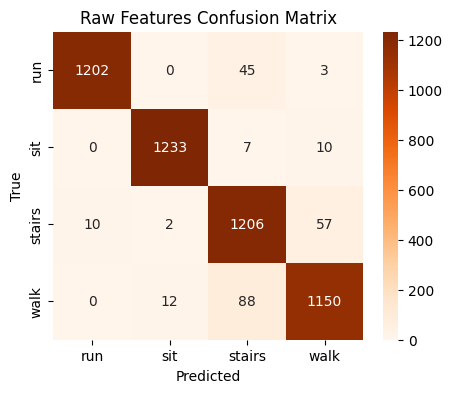

Dataset built: 5025 windows, 100 timesteps, 6 features

=== Fold 1 ===

=== Fold 2 ===

=== Fold 3 ===

=== Fold 4 ===

=== Fold 5 ===

=== GFT Features Classification Report ===
              precision    recall  f1-score   support

         run     0.9652    0.9760    0.9706      1250
         sit     0.9818    0.9480    0.9646      1250
      stairs     0.8399    0.8847    0.8617      1275
        walk     0.8704    0.8432    0.8566      1250

    accuracy                         0.9128      5025
   macro avg     0.9143    0.9130    0.9134      5025
weighted avg     0.9139    0.9128    0.9131      5025



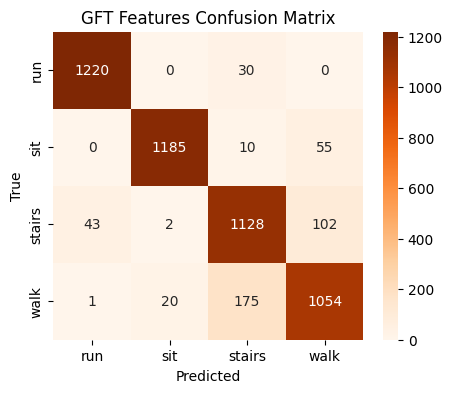

In [6]:
if __name__ == "__main__":
    recordings = load_selected_csvs(DATA_DIR)

    X_raw, y_raw, g_raw = build_dataset(recordings, RAW_FEATURES)
    evaluate_lstm(X_raw, y_raw, g_raw, title="Raw Features")

    X_gft, y_gft, g_gft = build_dataset(recordings, GFT_FEATURES)
    evaluate_lstm(X_gft, y_gft, g_gft, title="GFT Features")